In [28]:
import os
os.getcwd()
import pandas as pd
from sodapy import Socrata
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
import numpy as np
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import json
import requests 
import matplotlib.pyplot as plt
import seaborn as sns

Loading in and Preprocessing data

In [29]:
Traffic_Crashes_Crashes_df = pd.read_csv(r'data/Traffic_Crashes_Crashes.csv')
Traffic_Crashes_People_df = pd.read_csv(r'data/Traffic_Crashes_People.csv')
Traffic_Crashes_Crashes=Traffic_Crashes_Crashes_df[['CRASH_RECORD_ID','CRASH_DATE','POSTED_SPEED_LIMIT','TRAFFIC_CONTROL_DEVICE','WEATHER_CONDITION','LIGHTING_CONDITION','LATITUDE','LONGITUDE']]
Traffic_Crashes_People=Traffic_Crashes_People_df[['CRASH_RECORD_ID','PERSON_ID','SEX','AGE','CELL_PHONE_USE','INJURY_CLASSIFICATION','DRIVER_ACTION','PEDPEDAL_ACTION']]
merged_df = pd.merge(Traffic_Crashes_People, Traffic_Crashes_Crashes, on='CRASH_RECORD_ID', how='inner') 
merged_df = merged_df.dropna(subset=['LATITUDE', 'LONGITUDE'])
upper_left_lat = 41.920704
upper_left_lon = -87.680469
lower_right_lat = 41.837562
lower_right_lon = -87.608829 

filtered_df = merged_df[merged_df['POSTED_SPEED_LIMIT'] < 40]
filtered_df['CRASH_DATE'] = pd.to_datetime(filtered_df['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')
filtered_df = filtered_df[(filtered_df['CRASH_DATE'].dt.year == 2022) | (filtered_df['CRASH_DATE'].dt.year == 2023) | (filtered_df['CRASH_DATE'].dt.year == 2024)]
filtered_df = filtered_df[
    (filtered_df['LATITUDE'] <= upper_left_lat) &  # Latitudes must be less than or equal to upper-left corner latitude
    (filtered_df['LATITUDE'] >= lower_right_lat) &  # Latitudes must be greater than or equal to lower-right corner latitude
    (filtered_df['LONGITUDE'] >= upper_left_lon) &  # Longitudes must be greater than or equal to upper-left corner longitude
    (filtered_df['LONGITUDE'] <= lower_right_lon)   # Longitudes must be less than or equal to lower-right corner longitude
]
filtered_df = filtered_df.drop_duplicates(subset='CRASH_RECORD_ID')
print(len(filtered_df))
filtered_df.head(10)

C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\3119312667.py:1: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  Traffic_Crashes_Crashes_df = pd.read_csv(r'data/Traffic_Crashes_Crashes.csv')
C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\3119312667.py:2: DtypeWarning: Columns (19,23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  Traffic_Crashes_People_df = pd.read_csv(r'data/Traffic_Crashes_People.csv')
C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\3119312667.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['CRASH_DATE'] = pd.to_datetime(filtered_df['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')


52247


,CRASH_RECORD_ID,PERSON_ID,SEX,AGE,CELL_PHONE_USE,INJURY_CLASSIFICATION,DRIVER_ACTION,PEDPEDAL_ACTION,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,WEATHER_CONDITION,LIGHTING_CONDITION,LATITUDE,LONGITUDE
53,068e1ab19b8049e2186c1a8bea33e4651bb30b7f04d846...,O1304808,M,32.0,NaN,NONINCAPACITATING INJURY,NONE,NaN,2022-03-25 05:20:00,30,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",41.852956,-87.636874
128,0adb13d275b044a4b87b12a0f9cbd2ce5c99adf39d7644...,O1304838,M,24.0,NaN,NO INDICATION OF INJURY,FOLLOWED TOO CLOSELY,NaN,2022-03-25 07:20:00,30,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,41.887480,-87.616047
539,064e68e57992705eee351a7e4722fbe3dfcf10f066f351...,O1304845,F,33.0,NaN,NO INDICATION OF INJURY,OTHER,NaN,2022-03-25 07:39:00,10,NO CONTROLS,RAIN,DAYLIGHT,41.893576,-87.659367
540,9149f33c7674447f1a1433c33fa8bcb48ae658ab2371b8...,O1304847,F,47.0,NaN,NO INDICATION OF INJURY,IMPROPER BACKING,NaN,2022-03-25 07:53:00,10,NO CONTROLS,RAIN,DAYLIGHT,41.903311,-87.634606
578,8a438fda602185608c6aed66e436165a4e775a9ecfaaf9...,O1304938,M,29.0,NaN,NO INDICATION OF INJURY,IMPROPER LANE CHANGE,NaN,2022-03-25 09:30:00,25,NO CONTROLS,CLEAR,DAYLIGHT,41.879793,-87.642741
580,d339f7e09d3244b5f8c163fbf0e024555b026bcd0abb30...,O1304941,M,53.0,NaN,NO INDICATION OF INJURY,FAILED TO YIELD,NaN,2022-03-25 10:40:00,30,STOP SIGN/FLASHER,CLEAR,DAYLIGHT,41.890972,-87.674591
584,3b28caae2cbe2a1920313ac79720b242240b1798d986c8...,O1304954,M,NaN,NaN,NO INDICATION OF INJURY,IMPROPER BACKING,NaN,2022-03-25 10:35:00,30,NO CONTROLS,CLEAR,DAYLIGHT,41.868789,-87.640917
592,5f36fec62181189d625021027a91eb97f074f6ab93a4fc...,O1304973,M,35.0,NaN,NO INDICATION OF INJURY,NONE,NaN,2022-03-25 09:35:00,35,YIELD,CLOUDY/OVERCAST,DAYLIGHT,41.857605,-87.643636
607,47c78a32cc7002475971ce3f5128acafe8ba65ff3c71e9...,O1305001,M,52.0,NaN,NO INDICATION OF INJURY,NONE,NaN,2022-03-25 12:02:00,25,NO CONTROLS,CLEAR,DAYLIGHT,41.884579,-87.624605
615,aef2c3a9660ebeb73d088d018853214df0178cbfac58ce...,O1305010,X,NaN,NaN,NO INDICATION OF INJURY,UNKNOWN,NaN,2022-03-25 12:25:00,30,TRAFFIC SIGNAL,CLOUDY/OVERCAST,DAYLIGHT,41.899751,-87.667541


Finding Top Clusters

In [4]:
coords = filtered_df[['LATITUDE', 'LONGITUDE']].to_numpy()
radius_km = 0.01
eps = radius_km / 6371

db = DBSCAN(eps=eps, min_samples=5, metric='haversine').fit(np.radians(coords))
filtered_df['Cluster'] = db.labels_

cluster_counts = filtered_df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

cluster_counts = cluster_counts[cluster_counts['Cluster'] != -1]
top_clusters = cluster_counts.head(300)
top_clusters_list = top_clusters['Cluster'].tolist()
top_clusters_data = filtered_df[filtered_df['Cluster'].isin(top_clusters_list)]
top_cluster_centroids = top_clusters_data.groupby('Cluster')[['LATITUDE', 'LONGITUDE']].mean().reset_index()
top_cluster_centroids.columns = ['Cluster', 'Latitude', 'Longitude']
top_cluster_centroids = pd.merge(top_cluster_centroids, cluster_counts, on='Cluster')
top_cluster_centroids.rename(columns={'Count': 'Cluster_Count'}, inplace=True)
top_cluster_centroids = top_cluster_centroids.sort_values(by='Cluster_Count', ascending=False).reset_index(drop=True)
print(top_cluster_centroids)

     Cluster   Latitude  Longitude  Cluster_Count
0        139  41.869712 -87.643730            143
1        585  41.876411 -87.666690            143
2        329  41.900959 -87.619928            124
3        152  41.852358 -87.666174             99
4        674  41.890146 -87.647721             96
..       ...        ...        ...            ...
295      130  41.867385 -87.622645             21
296     1634  41.888071 -87.624056             21
297     1352  41.881524 -87.666941             21
298     1289  41.883159 -87.624520             21
299     1982  41.886007 -87.620829             21

[300 rows x 4 columns]


In [5]:
centroid_list = top_cluster_centroids[['Latitude', 'Longitude', 'Cluster_Count']].to_dict(orient='records')
with open('saved_jsons/centroids.json', 'w') as json_file:
    json.dump(centroid_list, json_file, indent=4)


Converting longitude and latitude to intersections 

In [6]:
geolocator = Nominatim(user_agent="intersection_finder")

def get_intersection(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address if location else "Unknown location"
    except GeocoderTimedOut:
        return "Timeout Error"

top_cluster_centroids['Intersection'] = top_cluster_centroids.apply(
    lambda row: get_intersection(row['Latitude'], row['Longitude']),
    axis=1
)

print(top_cluster_centroids)

     Cluster   Latitude  Longitude  Cluster_Count  \
0        139  41.869712 -87.643730            143   
1        585  41.876411 -87.666690            143   
2        329  41.900959 -87.619928            124   
3        152  41.852358 -87.666174             99   
4        674  41.890146 -87.647721             96   
..       ...        ...        ...            ...   
195       98  41.884395 -87.624578             26   
196      698  41.903887 -87.628829             26   
197     1157  41.892308 -87.629516             26   
198     1821  41.910944 -87.653170             26   
199     2093  41.883073 -87.639749             26   

                                          Intersection  
0    South Desplaines Street, Near West Side, Chica...  
1    320, South Ashland Avenue, Near West Side, Chi...  
2    East Lake Shore Drive, Magnificent Mile, Near ...  
3    West Cermak Road, Lower West Side, Chicago, We...  
4    442, North Halsted Street, River West, West To...  
..                   

In [ ]:
cluster_data = top_cluster_centroids["Intersection"].tolist()
with open("saved_jsons/Intersection_column.json", "w") as f:
    json.dump(cluster_data, f)

Preforming Correlation Analysis on being injured 

In [ ]:
analysis_df = filtered_df.copy()
analysis_df = analysis_df.dropna(subset=['INJURY_CLASSIFICATION'])
injury_mapping = {
    'NO INDICATION OF INJURY': 0,
    'REPORTED, NOT EVIDENT': 1,
    'NONINCAPACITATING INJURY': 1,
    'INCAPACITATING INJURY': 1,
    'FATAL': 1
}

analysis_df['INJURY'] = analysis_df['INJURY_CLASSIFICATION'].map(injury_mapping)
analysis_columns = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'AGE', 'CELL_PHONE_USE', 'INJURY']
analysis_df = analysis_df[analysis_columns]

encoded_df = pd.get_dummies(analysis_df, columns=['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'CELL_PHONE_USE'], drop_first=True)
correlation_with_severe_injury = encoded_df.corr()['INJURY'].sort_values(ascending=False)

print("Correlation with Injury:")
print(correlation_with_severe_injury)
correlation_with_severe_injury.to_csv("saved_jsons/severe_injury_correlation.csv", header=True)


Correlation with Injury:
INJURY                                             1.000000
TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL              0.056786
LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD          0.039753
TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER           0.035702
WEATHER_CONDITION_CLEAR                            0.021431
SEX_M                                              0.016758
LIGHTING_CONDITION_DAWN                            0.016407
TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN    0.013497
WEATHER_CONDITION_RAIN                             0.013079
TRAFFIC_CONTROL_DEVICE_FLASHING CONTROL SIGNAL     0.012445
WEATHER_CONDITION_FOG/SMOKE/HAZE                   0.010696
WEATHER_CONDITION_SLEET/HAIL                       0.006808
WEATHER_CONDITION_CLOUDY/OVERCAST                  0.006661
WEATHER_CONDITION_FREEZING RAIN/DRIZZLE            0.006176
TRAFFIC_CONTROL_DEVICE_SCHOOL ZONE                 0.003876
TRAFFIC_CONTROL_DEVICE_OTHER WARNING SIGN          0.002803
TRAFFIC_CONTROL

In [24]:
severe_accidents = filtered_df[filtered_df['INJURY_CLASSIFICATION'].isin(['INCAPACITATING INJURY', 'FATAL', 'REPORTED, NOT EVIDENT', 'NONINCAPACITATING INJURY'])]
categorical_columns = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'SEX', 'CELL_PHONE_USE']
category_counts_list = []

for col in categorical_columns:
    value_counts = severe_accidents[col].value_counts()
    temp_df = value_counts.reset_index()
    temp_df.columns = ['Value', 'Count']
    temp_df['Category'] = col  
    category_counts_list.append(temp_df)
    
category_counts_df = pd.concat(category_counts_list, ignore_index=True)
category_counts_df = category_counts_df.sort_values(by='Count', ascending=False)
total_count = category_counts_df['Count'].sum()
category_counts_df['Percentage'] = (category_counts_df['Count'] / total_count) * 100
print(category_counts_df)

                       Value  Count                Category  Percentage
12                     CLEAR   1357       WEATHER_CONDITION   20.467572
22                  DAYLIGHT   1030      LIGHTING_CONDITION   15.535445
28                         M    981                     SEX   14.796380
0             TRAFFIC SIGNAL    800  TRAFFIC_CONTROL_DEVICE   12.066365
29                         F    661                     SEX    9.969834
1                NO CONTROLS    574  TRAFFIC_CONTROL_DEVICE    8.657617
23    DARKNESS, LIGHTED ROAD    481      LIGHTING_CONDITION    7.254902
2          STOP SIGN/FLASHER    197  TRAFFIC_CONTROL_DEVICE    2.971342
13                      RAIN    183       WEATHER_CONDITION    2.760181
3                    UNKNOWN     56  TRAFFIC_CONTROL_DEVICE    0.844646
24                      DUSK     46      LIGHTING_CONDITION    0.693816
25                  DARKNESS     45      LIGHTING_CONDITION    0.678733
14           CLOUDY/OVERCAST     45       WEATHER_CONDITION    0

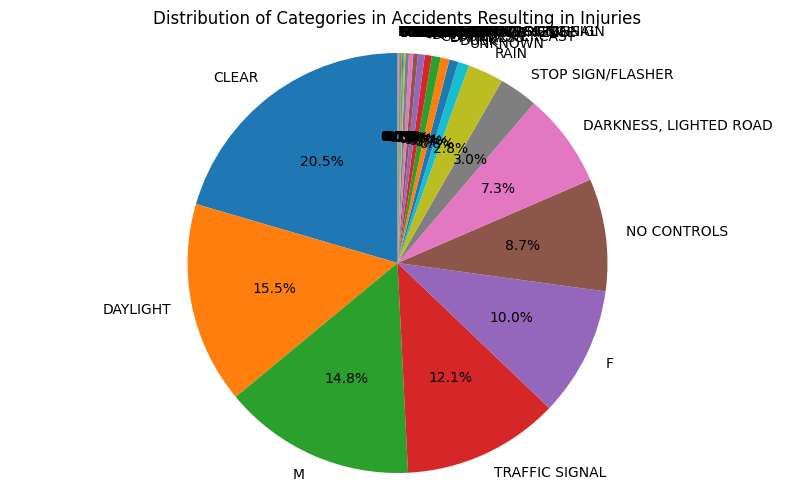

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.pie(category_counts_df['Percentage'], labels=category_counts_df['Value'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Categories in Accidents Resulting in Injuries')
plt.axis('equal')
plt.show()


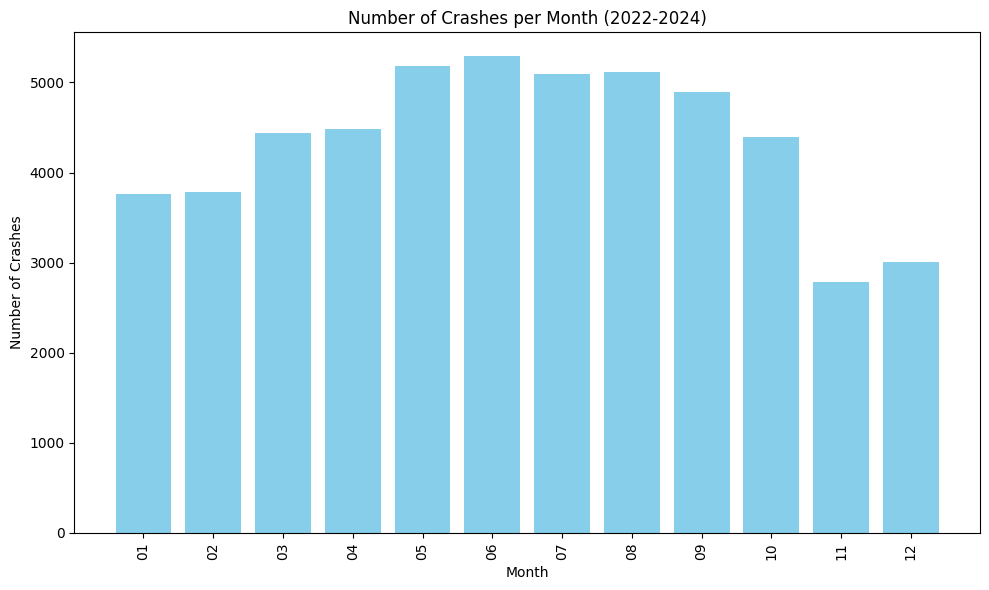

Month
01    3759
02    3784
03    4441
04    4488
05    5182
06    5292
07    5093
08    5116
09    4893
10    4400
11    2787
12    3012
Name: count, dtype: int64


In [56]:
filtered_df['Month'] = filtered_df['CRASH_DATE'].dt.strftime('%m')  
week_counts = filtered_df['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(week_counts.index, week_counts.values, width=0.8, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes per Month (2022-2024)')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()
print(week_counts)

Hour
0     1191
1      939
2      838
3      640
4      452
5      553
6      841
7     1632
8     2412
9     2457
10    2505
11    2666
12    3220
13    3166
14    3514
15    3913
16    4057
17    4119
18    3345
19    2520
20    2048
21    1863
22    1763
23    1593
Name: count, dtype: int64


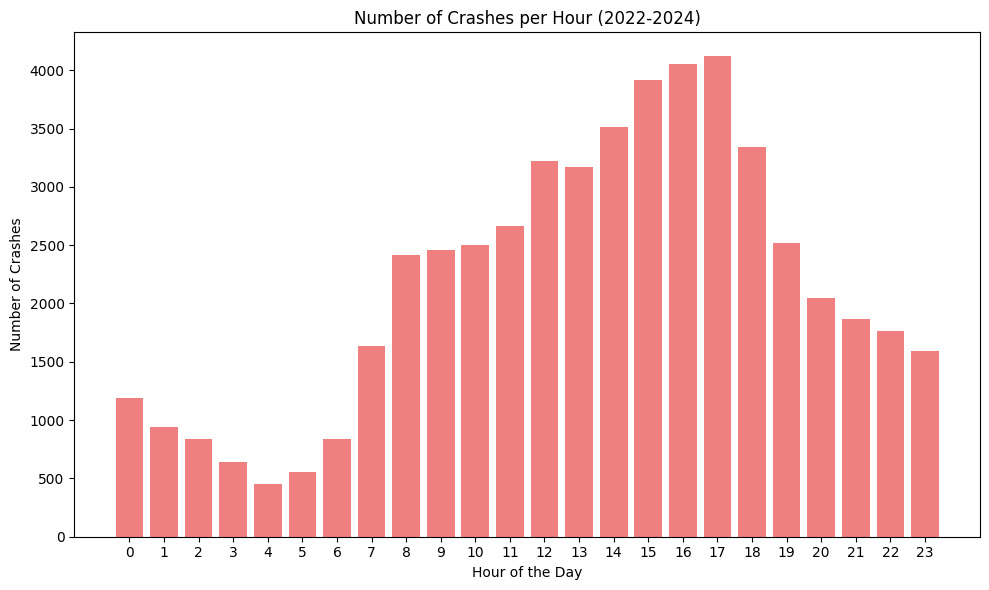

In [57]:
filtered_df['Hour'] = filtered_df['CRASH_DATE'].dt.hour
hour_counts = filtered_df['Hour'].value_counts().sort_index()
print(hour_counts)
plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, width=0.8, color='lightcoral')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes per Hour (2022-2024)')
plt.xticks(range(0, 24)) 
plt.tight_layout()
plt.show()


In [27]:
filtered_age_df = filtered_df.dropna(subset=['AGE'])
filtered_age_df['AGE'] = filtered_age_df['AGE'].astype(int)
age_stats = filtered_age_df['AGE'].describe()
print(age_stats)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
filtered_age_df['Age Group'] = pd.cut(filtered_age_df['AGE'], bins=bins)
age_group_counts = filtered_age_df['Age Group'].value_counts().sort_index()

count    32251.000000
mean        38.757248
std         15.871455
min          0.000000
25%         27.000000
50%         35.000000
75%         50.000000
max        100.000000
Name: AGE, dtype: float64


C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\3186732308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_age_df['AGE'] = filtered_age_df['AGE'].astype(int)
C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\3186732308.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_age_df['Age Group'] = pd.cut(filtered_age_df['AGE'], bins=bins)


C:\Users\jessi\AppData\Local\Temp\ipykernel_27468\1732017464.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SEX', y='AGE', data=filtered_age_df, palette='pastel')


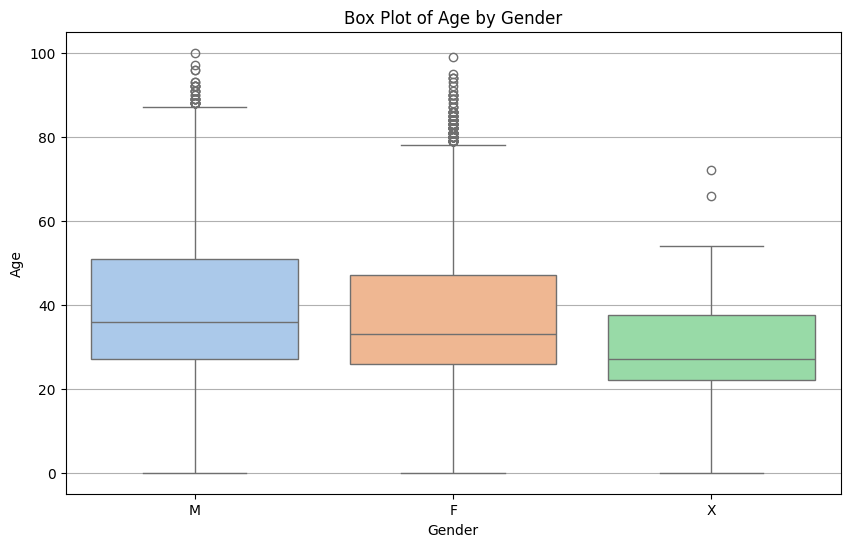

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEX', y='AGE', data=filtered_age_df, palette='pastel')
plt.title('Box Plot of Age by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.grid(axis='y')
plt.show()


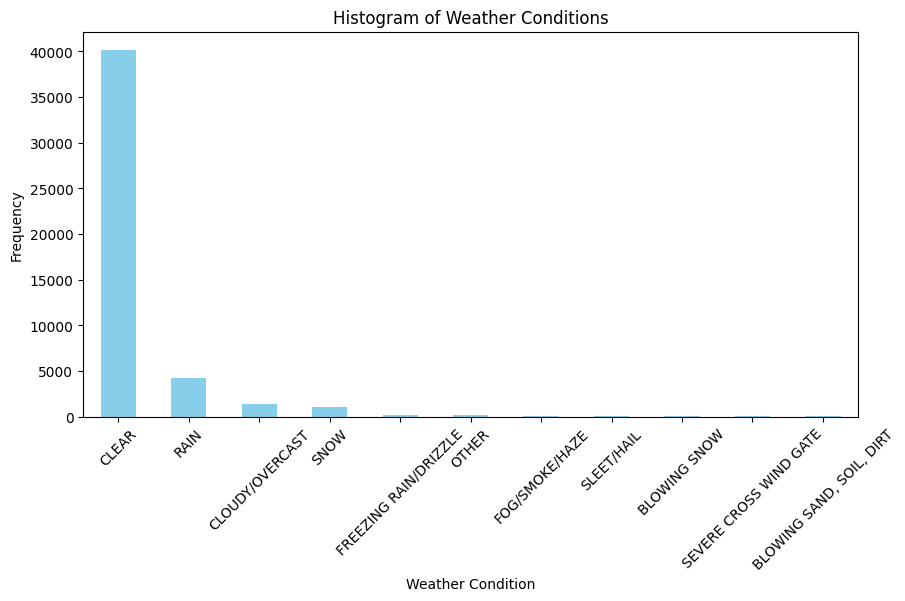

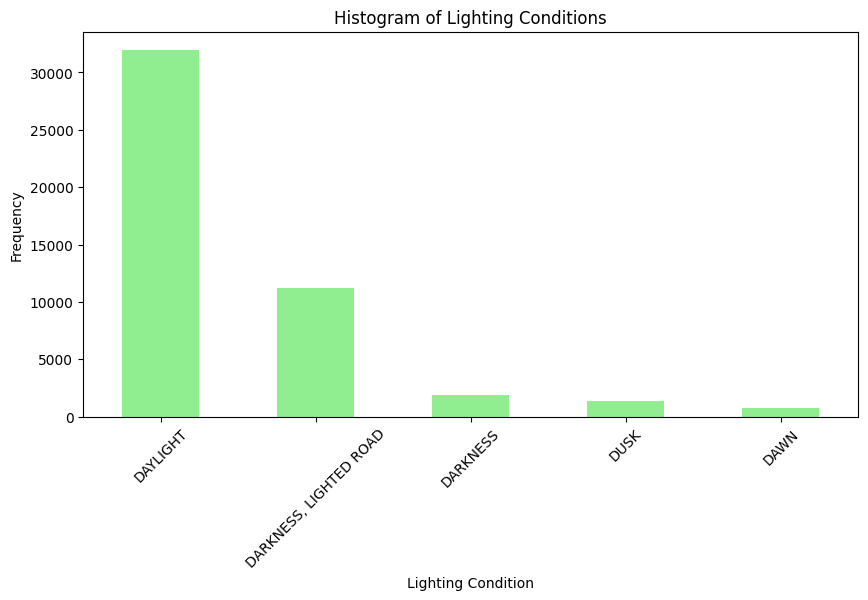

In [31]:
filtered_df1 = filtered_df[(filtered_df['WEATHER_CONDITION'] != 'UNKNOWN') & (filtered_df['LIGHTING_CONDITION'] != 'UNKNOWN')]
plt.figure(figsize=(10, 5))
filtered_df1['WEATHER_CONDITION'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histogram of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
filtered_df1['LIGHTING_CONDITION'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Histogram of Lighting Conditions')
plt.xlabel('Lighting Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
